In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.weight': 'bold'})

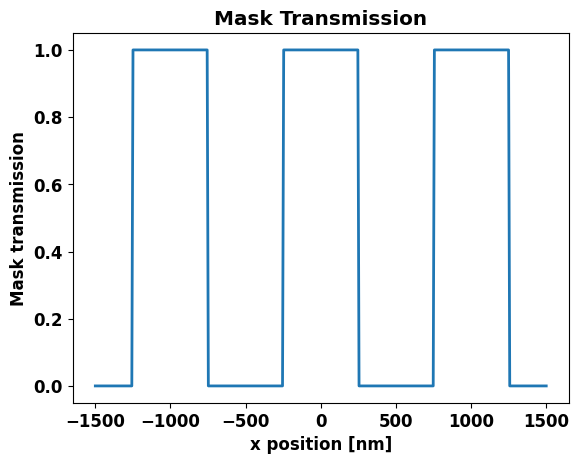

In [2]:
def line_space_msk(line_size,n_rep,nx):
    #Using Jupyter notebook the n_rep is set to float.
    #this cast it back to int. I don't know why, feel free to help.
    n_rep=int(n_rep)
    #Define the spatial support
    x_support=np.linspace(-line_size,line_size,nx)
    # Define the mask, 1 for glass, 0 for chromium
    # n_rep defines the mask repetition
    mask=[1 if np.abs(x)<line_size/2 else 0 for x in x_support]*n_rep
    # Update the support after mask multiplication
    nx*=n_rep
    x_support=np.linspace(-n_rep*line_size,n_rep*line_size,nx)
    dx=line_size*2*n_rep/nx
    return mask, x_support, dx, nx

mask, x_support, dx, nx=line_space_msk(line_size=500.,n_rep=3.,nx=128)
# Plot 
plt.title('Mask Transmission',fontweight='bold')
plt.plot(x_support,mask,linewidth=2)
plt.xlabel('x position [nm]',fontweight='bold')
plt.ylabel('Mask transmission',fontweight='bold')
plt.show()

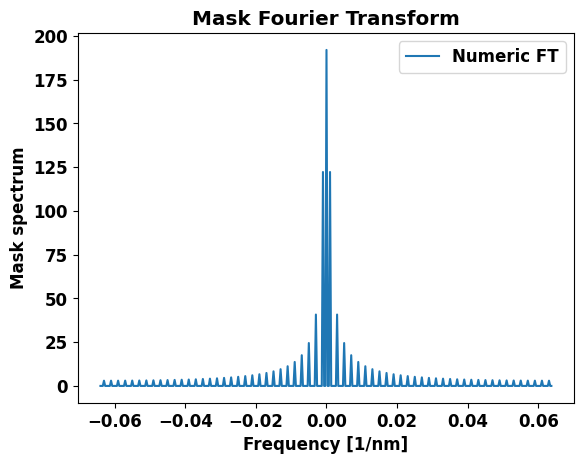

In [3]:
# Computation of the mask TF and its frequency support
mask_ft=np.fft.fftshift(np.fft.fft(mask))
# Do not forget the pixel size d when creating the frequency support
freq_support=np.fft.fftshift(np.fft.fftfreq(nx,d=dx))
# Plotting section
plt.title('Mask Fourier Transform',fontweight='bold')
plt.plot(freq_support,np.abs(mask_ft),label='Numeric FT')
plt.legend()
plt.xlabel('Frequency [1/nm]',fontweight='bold')
plt.ylabel('Mask spectrum',fontweight='bold')
plt.show()

In [4]:
def compute_defocus(defocus ,wavelength, freqx):
    #Compute the wave vector for the current wavelength.
    k = 2 * np.pi / wavelength
    # Compute the defocus aberration function.
    defocus_aberration=defocus * np.sqrt(1 - (wavelength * freqx) ** 2)
    aberration_function = np.exp(1j * k * defocus_aberration)
    return aberration_function

In [5]:
def compute_abbe(sigma, NA, wavelength, defocus, mask_ft, frq):
    # Define the effective source points of the circular source
    source_points=[f for f in frq if np.abs(f)<=sigma*NA/wavelength]
    # Initialisation of the aerial image as single precision
    aerial_image=np.zeros_like(mask_ft,dtype='float32')
    # Compute all source points contribution to the aerial image
    for freq_src in source_points:
        # Shift of the frequency support relative to the current source point frequency
        freq_msk_shft = [(f - freq_src) for f in frq]
        # Shifted transfer function of the projection lens with defocus aberration
        pupil_shifted = [compute_defocus(defocus,wavelength,f)  if np.abs(f) <= NA/wavelength 
                         else 0 for f in freq_msk_shft]
        # Compute the complete contribution 
        mask_lpf = np.multiply(mask_ft, pupil_shifted)
        # Add the contribution of the current src point to the overall aerial image
        aerial_image += np.abs(np.fft.ifft(mask_lpf)) ** 2
    # Normalisation with number of source points
    return aerial_image/len(source_points)

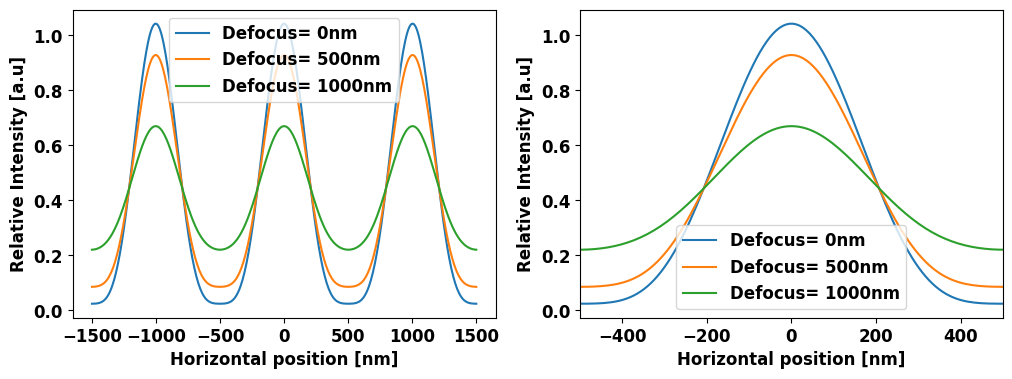

In [6]:
#Figure creation
fig,ax=plt.subplots(1,2,figsize=(12,4))
#Loop over all defocus values
for defocus in [0, 500, 1000]:
    # Compute the aerial image at the given defocus.
    int_profile=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,defocus=defocus,mask_ft=mask_ft,frq=freq_support)
    # Plot the intensity profile on two subplots
    ax[0].plot(x_support,int_profile,label=f'Defocus= {defocus}nm')
    ax[1].plot(x_support,int_profile,label=f'Defocus= {defocus}nm')

#Limit the x limits to match the article above.
ax[1].set_xlim(-500.,500.)
# Add axis decorators.
for ax in ax:
    ax.legend()
    ax.set_ylabel('Relative Intensity [a.u]',fontweight='bold')
    ax.set_xlabel('Horizontal position [nm]',fontweight='bold')

In [7]:
def compute_expo(stepper_defocus,thickness,dz,alpha=0.0005):
    #Compute the aerial image on top of the stack
    aerial_image=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,
                              defocus=stepper_defocus,mask_ft=mask_ft,
                              frq=freq_support)
    # Create a meshgrid corresponding to the resist coordinates in x and z direction
    nz=int(thickness/dz)
    z=np.linspace(0,thickness,nz)
    X,Z=np.meshgrid(x_support,z)
    # Bulk image computation without scaled defocus 
    aerial_image_no_defocus=np.stack([aerial_image for _ in range(nz)])
    #Stack the aerial image on itself
    bulk_ini=np.stack(aerial_image,0)
    # Apply vertical absorption
    bulk_img=bulk_ini*np.exp(-alpha*Z)
    
    return bulk_img

def compute_expo_scaled_defocus(stepper_defocus,thickness,dz,alpha=0.0005):
    #Compute the aerial image on top of the stack
    aerial_image=compute_abbe(sigma=0.5,NA=0.53,wavelength=365.,
                              defocus=stepper_defocus,mask_ft=mask_ft,
                              frq=freq_support)
    # Create a meshgrid corresponding to the resist coordinates in x and z direction
    nz=int(thickness/dz)
    z=np.linspace(0,thickness,nz)
    X,Z=np.meshgrid(x_support,z)
    # Optical index of the resist
    n_resist=1.5+1j*0.023
    #Compute all scaled z positions inside the resist thickness
    #The first position is not zero because it is already computed in aerial_image
    defocus_positions = np.arange(dz / np.real(n_resist)-stepper_defocus, 
                                  thickness / np.real(n_resist)-stepper_defocus,
                                  dz / np.real(n_resist))
    #Loop over all positions to compute the bulk image
    for defocus in defocus_positions:
        int_z=compute_abbe(sigma=0.7,NA=0.57,wavelength=365.,defocus=defocus,
                           mask_ft=mask_ft,frq=freq_support)
        aerial_image=np.vstack((aerial_image,int_z))
    # Apply vertical absorption
    bulk_img=aerial_image*np.exp(-alpha*Z)

    return bulk_img, X, Z

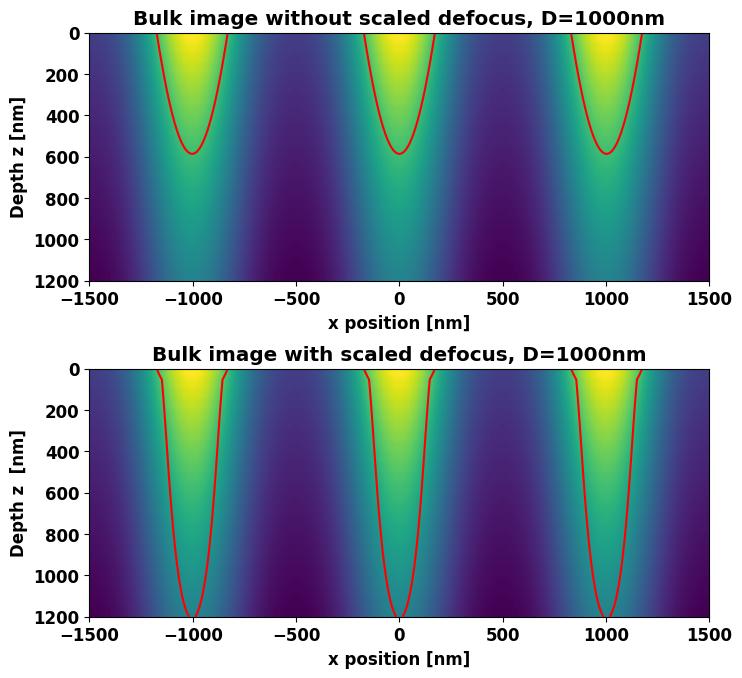

In [8]:
# Set defocus
stepper_defocus=1000
# Set resist thickness in nm
thickness=1200.
# Set pixel size along z direction
dz=50.
#Compute bulk image without scaled defocus
bulk_img_no_defocus=compute_expo(stepper_defocus,thickness,dz)
#Compute bulk image with scaled defocus
bulk_img_defocus,X, Z=compute_expo_scaled_defocus(stepper_defocus,thickness,dz)

# Plotting section
fig,ax=plt.subplots(2,1,figsize=(8,8))
ax[0].imshow(bulk_img_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[0].contour(X,Z,bulk_img_no_defocus,levels=[0.5],colors='r')
ax[0].set_xlabel('x position [nm]',fontweight='bold')
ax[0].set_ylabel('Depth z [nm]',fontweight='bold')
ax[0].set_title(f'Bulk image without scaled defocus, D={stepper_defocus}nm',fontweight='bold')
#With Scaled defocus
ax[1].imshow(bulk_img_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[1].contour(X,Z,bulk_img_defocus,levels=[0.5],colors='r')
ax[1].set_xlabel('x position [nm]',fontweight='bold')
ax[1].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[1].set_title(f'Bulk image with scaled defocus, D={stepper_defocus}nm',fontweight='bold')
plt.show()

In [9]:
def compute_exposition(bulk_ini,dose=1700.):
    # Initialise latent image
    lat_img=np.ones_like(bulk_ini)
    # Instanciate resist parameters A in [1/nm], A in [1/nm] and C in [m²/J]
    dill_a=0.00075
    dill_b=0.00005
    dill_c=0.0025
    # Typical lamp power in W/m²
    lamp_power=30000
    # Exposure time in s
    t_tot=dose/lamp_power
    n_steps=50
    # Discretize exposure time
    time_step=t_tot/n_steps
    #Copy the initial bulk image to start iteration
    bulk_img=bulk_ini.copy()
    # Loop to compute exposition
    for n in range(n_steps):
        # Latent image update
        lat_img*=np.exp(-dill_c*bulk_img*time_step*lamp_power)
        # Absorption coefficient update
        alpha=dill_a*lat_img+dill_b
        # Bulk image update
        bulk_img=bulk_ini*np.exp(-alpha*Z)
    
    return lat_img,bulk_img

In [10]:
# This function computes the developement rate according to the 4 parameters model from Mack.
def Mack_Developement_Rate(latent_img, m_th, r_min, r_max, n):
    a_mack = (1 - m_th) ** n
    a_mack *= (n + 1) / (n - 1)
    dev_rate = (a_mack + 1) * (1 - latent_img) ** n
    dev_rate /= a_mack + (1 - latent_img) ** n
    dev_rate *= r_max
    dev_rate += r_min
    dev_rate = np.clip(dev_rate, r_min, r_max)
    return dev_rate

In [11]:
import skfmm
def compute_development(lat_img, dev_rate):
    # Fast Marching require a negative frontier to compute travel time
    # We add this frontier artifically (it will be removed later)
    neg_layer = -1 * np.ones_like(lat_img[0, :])
    lat_img = np.vstack((lat_img, neg_layer))
    cur_dev_rate = np.vstack((neg_layer, dev_rate))
    # Compute fast marching (! the algorithm flips the array along axis 0)
    time_resist_fmm = skfmm.travel_time(lat_img, cur_dev_rate, dx=[dz, dx],periodic=[False,True])
    # Remove artificial negative layer
    time_resist_fmm=time_resist_fmm[1:,:]
    # Flip array back to normal
    time_resist_fmm=np.rot90(time_resist_fmm,k=2)
    return time_resist_fmm

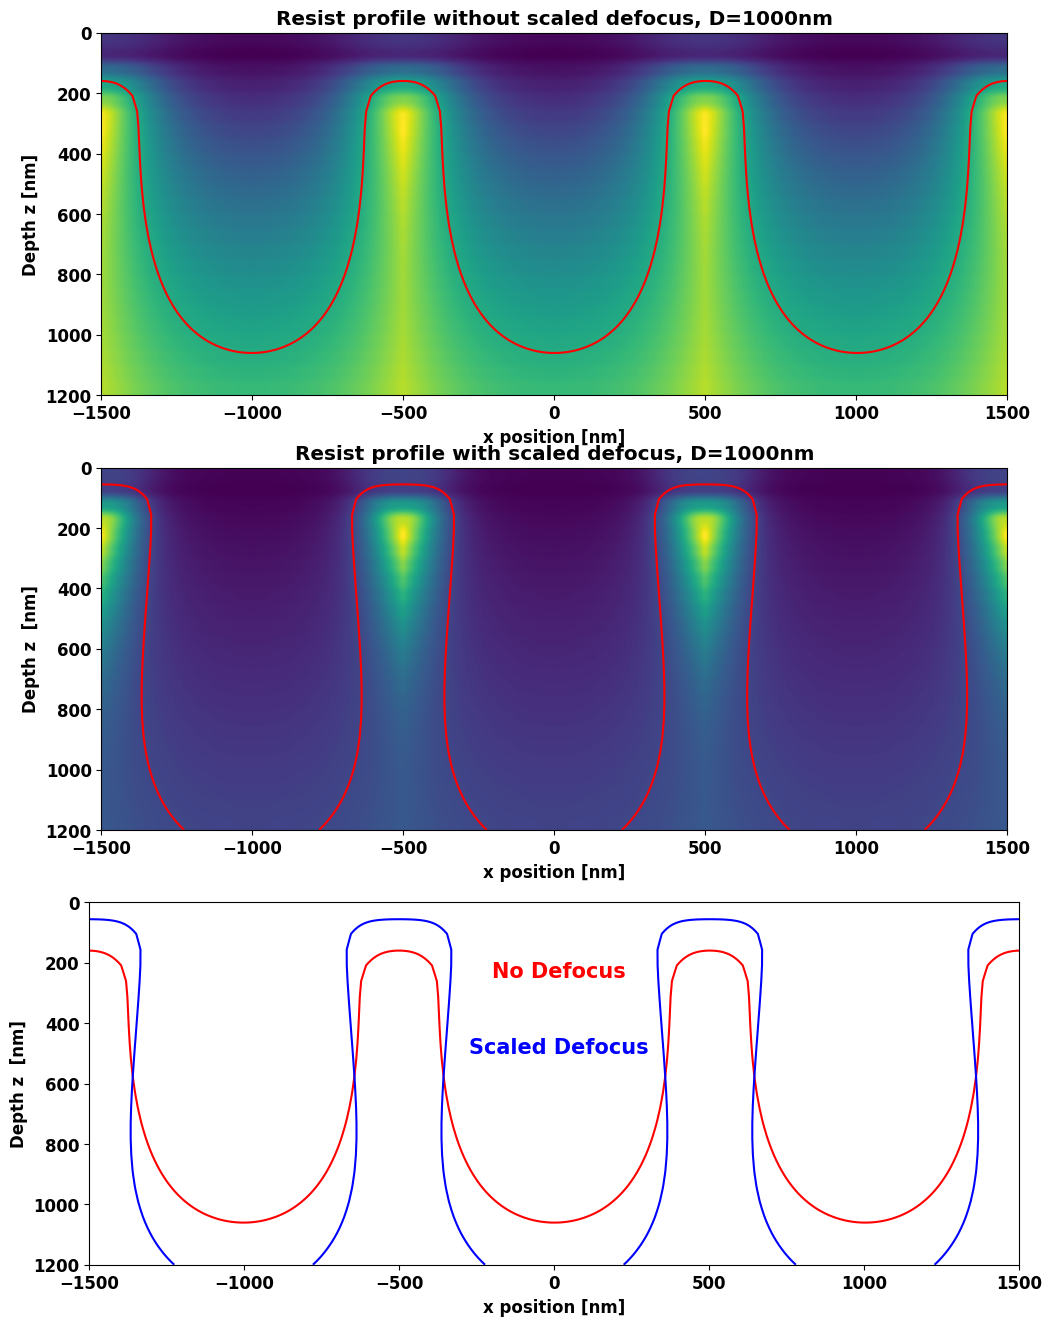

In [12]:
#Compute the final latent images with and without scaled defocus
lat_img_no_defocus,_=compute_exposition(bulk_img_no_defocus)
lat_img_defocus,_=compute_exposition(bulk_img_defocus)
#Compute the dev rate functions with Mack model
dev_rate_no_defocus=Mack_Developement_Rate(latent_img=lat_img_no_defocus, m_th=0.01, r_min=0.8, r_max=50, n=2)
dev_rate_defocus=Mack_Developement_Rate(latent_img=lat_img_defocus, m_th=0.01, r_min=0.8, r_max=50, n=2)
# Compute the resist development.
time_no_defocus=compute_development(lat_img_no_defocus,dev_rate_no_defocus)
time_defocus=compute_development(lat_img_defocus,dev_rate_defocus)
# Plotting section
fig,ax=plt.subplots(3,1,figsize=(12,16))
ax[0].imshow(time_no_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[0].contour(X,Z,time_no_defocus,levels=[30.],colors='r')
ax[0].set_xlabel('x position [nm]',fontweight='bold')
ax[0].set_ylabel('Depth z [nm]',fontweight='bold')
ax[0].set_title(f'Resist profile without scaled defocus, D={stepper_defocus}nm',fontweight='bold')
#With Scaled defocus
ax[1].imshow(time_defocus,extent = [np.min(x_support) , np.max(x_support), thickness ,0])
ax[1].contour(X,Z,time_defocus,levels=[30.],colors='r')
ax[1].set_xlabel('x position [nm]',fontweight='bold')
ax[1].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[1].set_title(f'Resist profile with scaled defocus, D={stepper_defocus}nm',fontweight='bold')
# Both profiles on same graph
ax[2].contour(X,Z,time_no_defocus,levels=[30.],colors='r')
ax[2].contour(X,Z,time_defocus,levels=[30.],colors='b')
ax[2].set_xlabel('x position [nm]',fontweight='bold')
ax[2].set_ylabel('Depth z  [nm]',fontweight='bold')
ax[2].text(-200, 250, 'No Defocus',color='r',weight='bold',size=15)
ax[2].text(-275, 500, 'Scaled Defocus',color='b',weight='bold',size=15)
ax[2].set_xlim(np.min(x_support) , np.max(x_support))
ax[2].set_ylim(thickness ,0)
plt.show()